### PLACE ALL IMPORTS HERE (easier to keep track of)

In [243]:
# general
from __future__ import division
from collections import defaultdict
from collections import Counter
import os
import random
import re

# to read in JSON character objects 
import json

# for stopwords
import nltk
from nltk.tokenize import RegexpTokenizer

# for LDA topic modeling
from gensim import corpora, models, similarities, matutils

# for lots of math junk and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# for making data frames
import pandas as pd
# for clustering, etc.
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

from scipy.cluster.hierarchy import ward, dendrogram
import scipy.stats as stats


# Read in character JSON, build feature vectors for a BOW-type model

Things to do: Fiddle with the mention threshold, dialogue features (to include or not to include?), maybe throw out the most common attributes afterward

**NOTE: All of this functionality is now located in the loadCharFeatures module**

getCharVectorsFromJson takes the following args:
    - mention_threshold (defaults to 100)
    - use_stopwords (defaults to true)
    - book_src_dir (pass in path to the raw book text)
    - json_filename (pass in path to the booknlp json file output)

In [244]:
import loadCharFeatures
reload(loadCharFeatures)
(characters, character_namelists, total_features, top_n) = loadCharFeatures.getCharVectorsFromJson(use_stopwords = True, 
                                                                                                   mention_threshold = 60)

Most common words in book:  [('the', 47552.0), ('to', 26268.0), ('and', 25179.0), ('of', 21444.0), ('a', 19852.0), ('.', 17618.0), ('was', 15155.0), ('he', 14435.0), ('his', 13612.0), ('said', 12682.0), ('in', 11952.0), ('Harry', 11326.0), ('had', 9954.0), ('that', 8840.0), ('at', 8322.0), ('you', 8044.0), ('it', 7310.0), ('I', 7282.0), ('as', 7026.0), ('with', 6272.0), ('on', 6097.0), ('for', 5193.0), ('He', 4990.0), ('not', 4666.0), ('\xc2\x91', 4527.0), ('her', 4418.0), ('they', 4259.0), ('be', 4258.0), ('were', 4155.0), ('but', 4010.0), ('from', 3997.0), ('have', 3970.0), ('out', 3847.0), ('him', 3806.0), ('\xe2\x80\x94', 3561.0), ('she', 3462.0), ('up', 3432.0), ('into', 3427.0), ('Ron', 3366.0), ('all', 3336.0), ('The', 3250.0), ('been', 3136.0), ('Hermione', 3119.0), ('what', 2798.0), ('could', 2668.0), ('back', 2595.0), ('who', 2581.0), ('their', 2497.0), ('is', 2491.0), ('them', 2482.0), ('Harry,', 2400.0), ('\xe2\x80\x9cI', 2326.0), ('looked', 2321.0), ('about', 2282.0), ('so

**Create texts to feed to gensim, print out BOW for each character**

In [245]:
texts = [None for key in characters]
names = {}
i = 0
for key, value in characters.iteritems():
    print str(key) + ": " + str(value)
    texts[i] = value
    names[key] = i
    i += 1
    print
print len(characters)

Fang: [u'take_PATIENT', u'swept_PATIENT', u'bless_PATIENT', u'take_PATIENT', u'fend_PATIENT', u'leav_PATIENT', u'carri_PATIENT', u'push_PATIENT', u'bowl_PATIENT', u'stroke_PATIENT', u'found_PATIENT', u'want_PATIENT', u'transfix_PATIENT', u'start_AGENT', u'bound_AGENT', u'yelp_AGENT', u'kept_AGENT', u'whimper_AGENT', u'fight_AGENT', u'thud_AGENT', u'howl_AGENT', u'howl_AGENT', u'fling_himself_AGENT', u'trembl_AGENT', u'ter_AGENT', u'shove_i_AGENT', u'lollop_AGENT', u'gallop_AGENT', u'save__AGENT', u'move_AGENT', u'reach_edg_AGENT', u'stop_AGENT', u'feel_chil_AGENT', u'control_own_AGENT', u'breath_AGENT', u'cling_AGENT', u'pull_it_AGENT', u'stare_AGENT', u'want_tim_AGENT', u'press_met_AGENT', u'lower_hand_AGENT', u'whimper_AGENT', u'won_AGENT', u'scratch_whin_AGENT', u'bark_AGENT', u'launch_himself_AGENT', u'trot_AGENT', u'bound_AGENT', u'strode_AGENT', u'give_bark_AGENT', u'jump_AGENT', u'lay_head_AGENT', u'come_pad_AGENT', u'howl_AGENT', u'keep_AGENT', u'dance_al_AGENT', u'take_gulp_AG

**Print most common features (to do: maybe filter these out of the model?)**

In [246]:
counter = Counter(total_features)
top_n = counter.most_common(30)
print top_n
print

# remove these words from the texts before doing topic modeling
for text in texts:
    for word_tupe in top_n:
        while word_tupe[0] in text:
            text.remove(word_tupe[0])
#print texts

[(u'wand_POSS', 930.0), (u'want_AGENT', 437.0), (u'want_SAY', 415.0), (u'right_SAY', 402.0), (u'turn_AGENT', 400.0), (u'oh_SAY', 392.0), (u'yes_SAY', 350.0), (u'tri_AGENT', 340.0), (u'stare_AGENT', 331.0), (u'yeah_SAY', 307.0), (u'potter_SAY', 290.0), (u'time_SAY', 286.0), (u'good_SAY', 265.0), (u'shoulder_POSS', 261.0), (u'tell__AGENT', 252.0), (u'stood_AGENT', 250.0), (u'walk_AGENT', 247.0), (u'sat_AGENT', 246.0), (u'whi_SAY', 245.0), (u'robe_POSS', 244.0), (u'realli_SAY', 228.0), (u'tri_SAY', 225.0), (u'never_SAY', 217.0), (u'mean_SAY', 216.0), (u'hair_POSS', 214.0), (u'voldemort_SAY', 211.0), (u'thing_SAY', 209.0), (u'ear_POSS', 206.0), (u'heard_AGENT', 201.0), (u'cours_SAY', 200.0)]



## Do LDA/HDP Topic Modeling Using Character Features

In [247]:
# create Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# create bag of words model to perform analysis
corpus = [dictionary.doc2bow(text) for text in texts]

hdp = False

if(hdp):
    # hdp topic modeling
    hdp = models.HdpModel(corpus, id2word=dictionary)
    topics = hdp.print_topics(topics=-1, topn=20)
    numtopics = len(topics)
    print numtopics
else:
    # lda topic modeling
    numtopics = 25
    lda = models.LdaModel(corpus, num_topics=numtopics, 
                                id2word=dictionary, 
                                update_every=5, 
                                chunksize=100, 
                                passes=100)

The following commented code is an attempt to determine the optimal number of clusters using the Arun, et al. measure. Implementation credit goes to Christopher Grainger (http://blog.cigrainger.com/2014/07/lda-number.html). However, we are not using it at this time because it takes too long/too much memory to run and doesn't necessarily produce useful results.

In [248]:
# Define KL function
# def sym_kl(p,q):
#     return np.sum([stats.entropy(p,q),stats.entropy(q,p)])

# l = np.array([sum(cnt for _, cnt in doc) for doc in corpus])
# def arun(corpus,dictionary,min_topics=1,max_topics=50,step=3):
#     kl = []
#     for i in range(min_topics,max_topics,step):
#         print i
#         lda = models.LdaModel(corpus=corpus,
#             id2word=dictionary,num_topics=i,passes=20)
#         m1 = lda.expElogbeta
#         U,cm1,V = np.linalg.svd(m1)
#         #Document-topic matrix
#         lda_topics = lda[corpus]
#         m2 = matutils.corpus2dense(lda_topics, lda.num_topics).transpose()
#         cm2 = l.dot(m2)
#         cm2 = cm2 + 0.0001
#         cm2norm = np.linalg.norm(l)
#         cm2 = cm2/cm2norm
#         kl.append(sym_kl(cm1,cm2))
#     return kl
    
# kl = arun(corpus,dictionary)
# # Plot kl divergence against number of topics
# plt.plot(kl)
# plt.ylabel('Symmetric KL Divergence')
# plt.xlabel('Number of Topics')
# plt.savefig('kldiv.png', bbox_inches='tight')

In [249]:
#hdp.show_topics(topics=-1, topn=20, log=False, formatted=True)
# for topic in topics:
#     print topic
#     print

def hdpToLDA(hdpModel):
    lda = models.LdaModel(id2word=hdpModel.id2word, 
    num_topics=numtopics, eta=hdpModel.m_eta) 
    return lda

if hdp:
    lda = hdpToLDA(hdp)
print(lda.show_topics())

[u'0.033*yeh_SAY + 0.029*ter_SAY + 0.016*cabin_POSS + 0.010*fer_SAY + 0.010*o_SAY + 0.009*jus_SAY + 0.008*yer_SAY + 0.007*tha_SAY + 0.006*em_SAY + 0.006*hut_POSS', u'0.004*cedric_SAY + 0.003*follow_PATIENT + 0.003*watch_PATIENT + 0.002*sure_MOD + 0.002*expect_AGENT + 0.002*return_AGENT + 0.002*understand_AGENT + 0.002*send_SAY + 0.002*mind_SAY + 0.002*stand_AGENT', u'0.006*offic_POSS + 0.005*ruff_POSS + 0.004*leav_SAY + 0.003*bustl_AGENT + 0.003*abl_MOD + 0.003*glide_AGENT + 0.003*lip_POSS + 0.002*recogn_PATIENT + 0.002*door_POSS + 0.002*tone_POSS', u'0.004*sure_MOD + 0.004*heart_POSS + 0.004*mind_POSS + 0.004*scar_POSS + 0.003*feel_AGENT + 0.003*glanc_AGENT + 0.003*stomach_POSS + 0.003*realiz_AGENT + 0.003*found_AGENT + 0.003*bed_POSS', u'0.005*room_POSS + 0.004*predict_POSS + 0.003*stand_AGENT + 0.003*classroom_POSS + 0.002*magic_SAY + 0.002*began_AGENT + 0.002*chair_POSS + 0.002*continu_AGENT + 0.002*tell_i_AGENT + 0.002*word_POSS', u'0.015*clipboard_POSS + 0.013*offic_POSS + 0.006*

#### Print top n words for each topic

Word Clouds for each topic generated using the wordcloud package - use "pip install wordcloud" (http://peekaboo-vision.blogspot.de/2012/11/a-wordcloud-in-python.html)

Topic  0
sister_POSS king_MOD dad_POSS weasley_SAY georg_SAY bed_POSS ze_SAY fred_SAY thank_SAY montagu_SAY ave_SAY groan_AGENT bludger_SAY vanish_AGENT rat_POSS quaffl_SAY bill_SAY slytherin_SAY disappear_AGENT sit_AGENT left_AGENT blimey_SAY tell_i_AGENT bell_SAY dad_SAY famili_POSS keep_SAY pillow_POSS mother_POSS fine_SAY 


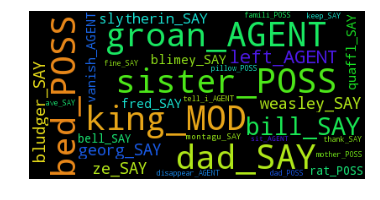

0
Topic  1
dobbi_SAY sir_SAY son_POSS left_PATIENT leav_PATIENT father_SAY scoop_POSS articl_POSS work_AGENT winki_SAY bag_POSS doe_SAY master_SAY handbag_POSS take_SAY quill_POSS inform_SAY appear_AGENT found_PATIENT azkaban_SAY squeak_PATIENT do_it_AGENT name_SAY need_SAY befor_SAY glass_POSS power_SAY magic_SAY move_AGENT boy_SAY 


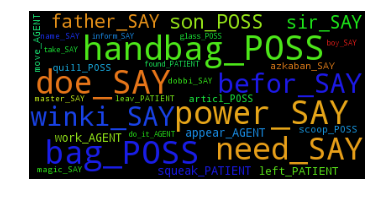

1
Topic  2
mind_POSS scar_POSS ad_AGENT mother_POSS father_POSS heart_POSS take_SAY suppos_SAY onli_SAY becaus_SAY realiz_AGENT sit_AGENT sure_MOD year_SAY offic_POSS glanc_AGENT make_SAY move_AGENT ask__AGENT magic_SAY glass_POSS return_AGENT hagrid_SAY leav_PATIENT ministri_SAY way_POSS pocket_POSS bed_POSS last_SAY need_SAY 


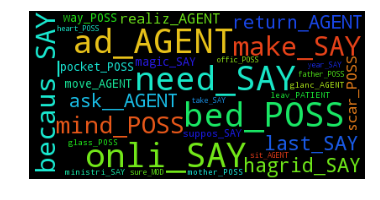

2
Topic  3
becaus_SAY sure_MOD glanc_AGENT need_SAY move_AGENT sir_SAY year_SAY make_SAY snape_SAY heart_POSS mind_POSS ask__AGENT someth_SAY watch_PATIENT mother_POSS last_SAY hagrid_SAY hogwart_SAY ad_AGENT doe_SAY suppos_SAY offic_POSS keep_SAY sirius_SAY stop_AGENT sure_SAY take_SAY boy_SAY found_AGENT find_SAY 


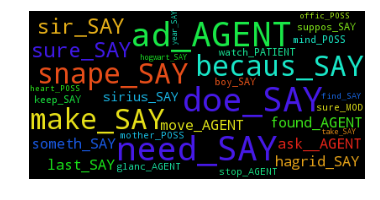

3
Topic  4
die_AGENT letter_POSS kill_PATIENT parent_POSS godfath_POSS escap_AGENT crouch_SAY death_POSS mother_POSS father_POSS scream_AGENT help_PATIENT kill_SAY dead_MOD sirius_SAY group_SAY sister_POSS watch_PATIENT feel_AGENT laugh_AGENT year_SAY snape_SAY hous_POSS betray_PATIENT rememb_PATIENT caught_PATIENT mention_PATIENT gone_AGENT smile_AGENT suggest_AGENT 


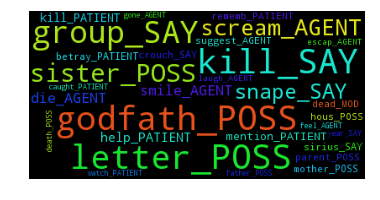

4
Topic  5
master_SAY do_what_AGENT kreacher_SAY father_POSS weasley_SAY return_AGENT kill_PATIENT mother_POSS soul_POSS mind_POSS support_POSS talk_AGENT malfoy_SAY name_POSS stand_AGENT horcrux_POSS move_AGENT boy_SAY say_what_AGENT roar_PATIENT lord_SAY call_PATIENT gone_AGENT watch_PATIENT fail_AGENT abl_MOD hous_SAY vanish_AGENT take_SAY stop_AGENT 


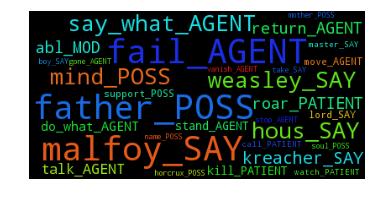

5
Topic  6
dear_SAY arthur_SAY son_POSS father_SAY glass_POSS husband_POSS ad_AGENT call_AGENT watch_POSS better_SAY lip_POSS boy_SAY befor_SAY enough_SAY follow_PATIENT suppos_SAY chair_POSS smile_AGENT onli_SAY much_SAY snap_AGENT sob_AGENT start_AGENT hurri_AGENT molli_SAY appear_AGENT take_SAY wizard_SAY anyon_SAY bed_SAY 


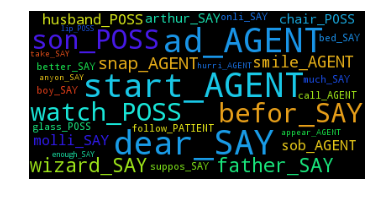

6
Topic  7
mum_SAY pocket_POSS year_SAY dad_SAY watch_PATIENT anyon_SAY perci_SAY becaus_SAY bit_SAY take_SAY lot_SAY ear_SAY mother_POSS sit_AGENT room_SAY bet_SAY make_SAY old_SAY keep_SAY follow_PATIENT work_SAY set_AGENT bagman_SAY follow_AGENT age_SAY yet_SAY laugh_AGENT ask__AGENT might_SAY littl_SAY 


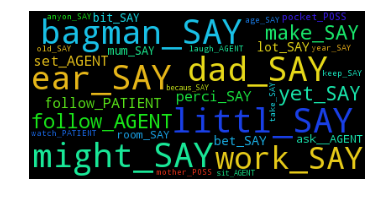

7
Topic  8
cedric_SAY follow_PATIENT watch_PATIENT sure_MOD expect_AGENT return_AGENT understand_AGENT send_SAY mind_SAY stand_AGENT umbridg_SAY see_it_AGENT two_SAY ask__AGENT start_AGENT fell_AGENT show_pleasur_AGENT hi_SAY approach_AGENT brave_AGENT coffe_SAY sworn_PATIENT need_inform_AGENT mention_AGENT stomach_POSS explain_it_AGENT heavi_SAY continu_SAY swoop_AGENT wizard_MOD 


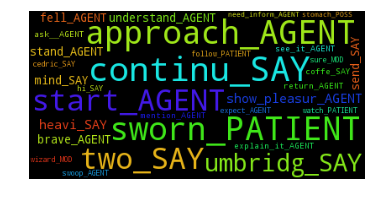

8
Topic  9
offic_POSS ruff_POSS leav_SAY bustl_AGENT abl_MOD glide_AGENT lip_POSS recogn_PATIENT door_POSS tone_POSS allow_SAY hat_POSS certain_SAY headmast_SAY point_SAY enough_SAY laugh_AGENT sick_SAY feast_SAY parti_POSS disappear_AGENT food_SAY sigh_AGENT doublet_POSS pension_SAY audienc_POSS beauti_MOD stand_hand_AGENT hold_bottl_AGENT clean_AGENT 


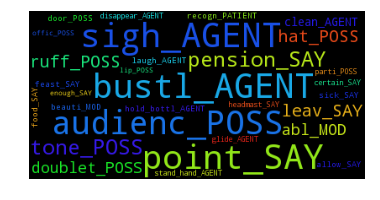

9
Topic  10
dark_SAY draco_SAY certain_SAY lord_SAY miss_SAY dear_SAY rasp_PATIENT narcissa_SAY breath_POSS sit_AGENT onli_SAY chair_POSS malfoy_SAY doe_SAY snarl_PATIENT word_SAY noth_SAY leav_SAY call_AGENT someth_SAY hi_SAY cup_SAY remus_SAY kind_SAY seize__AGENT dare_SAY snape_SAY ad_AGENT wizard_SAY lucius_SAY 


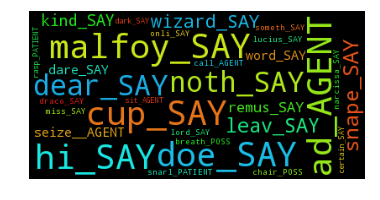

10
Topic  11
grandmoth_POSS parent_POSS toad_POSS mother_POSS gran_SAY help_PATIENT badg_POSS tell_they_AGENT bed_POSS choke_AGENT chest_POSS jump_AGENT ran_AGENT manag_AGENT nod_AGENT pocket_POSS someth_SAY tell_i_AGENT great_SAY wife_POSS first_SAY sort_SAY do_it_AGENT gryffindor_SAY seat_POSS father_POSS set_AGENT do_what_AGENT kept_AGENT appear_AGENT 


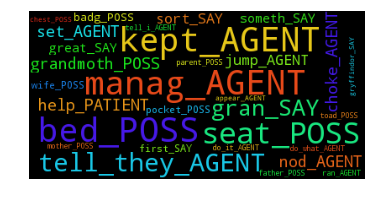

11
Topic  12
friend_POSS mother_POSS father_POSS cloak_POSS pocket_POSS son_POSS roar_AGENT hear_AGENT die_AGENT stand_SAY disappear_AGENT brother_POSS invis_SAY hold_PATIENT drop_SAY snog_SAY take_AGENT betray_PATIENT asid_SAY wake_SAY jerk_wand_AGENT onli_SAY glanc_AGENT take_SAY start_AGENT pleas_SAY ad_AGENT last_SAY name_POSS okay_SAY 


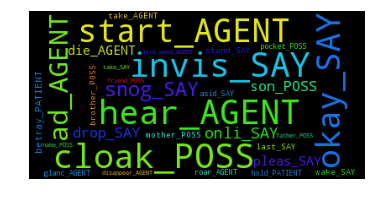

12
Topic  13
room_POSS predict_POSS stand_AGENT classroom_POSS magic_SAY began_AGENT chair_POSS continu_AGENT tell_i_AGENT word_POSS leav_SAY gone_AGENT side_POSS finish_SAY lose_SAY howev_SAY dismiss_SAY swept_AGENT opportun_SAY propheci_POSS predict_death_AGENT divin_SAY talk_POSS move_AGENT take_SAY onli_SAY way_SAY sit_AGENT anyth_SAY littl_SAY 


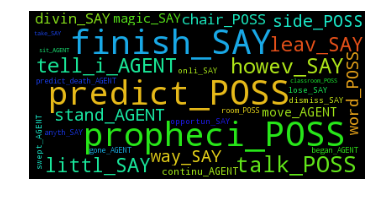

13
Topic  14
diari_POSS diari_POSS tom_SAY sir_SAY wizard_SAY school_SAY get_award_AGENT attack_SAY express_POSS name_POSS hogwart_SAY move_AGENT kill_SAY smile_AGENT aliv_SAY ad_AGENT call_SAY stop_SAY jump_AGENT even_SAY die_SAY doe_SAY sword_SAY watch_PATIENT stop_AGENT power_SAY need_SAY nod_AGENT award_POSS cat_SAY c'mon_SAY 


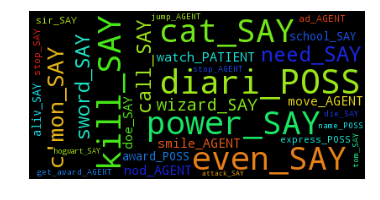

14
Topic  15
yeh_SAY yeh_SAY yeh_SAY yeh_SAY ter_SAY ter_SAY ter_SAY cabin_POSS cabin_POSS fer_SAY fer_SAY o_SAY o_SAY jus_SAY yer_SAY tha_SAY em_SAY hut_POSS door_POSS bin_SAY hous_POSS bit_SAY righ_SAY visit_PATIENT hogwart_SAY growl_PATIENT abou_SAY tale_POSS won_SAY worri_SAY great_SAY growl_AGENT fight_SAY goin_SAY fine_SAY fang_SAY grunt_AGENT littl_SAY 


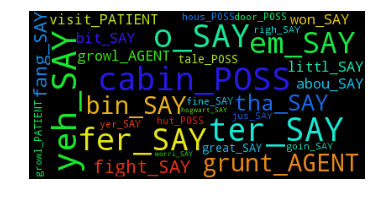

15
Topic  16
friend_POSS muggl_SAY squeak_PATIENT return_AGENT class_POSS offic_POSS hit_PATIENT left_AGENT gone_AGENT pocket_POSS call_AGENT pipe_PATIENT pass_PATIENT giggl_AGENT cup_SAY sit_AGENT won_SAY classroom_POSS help_PATIENT appear_AGENT older_SAY tell_i_AGENT call_PATIENT laugh_AGENT stop_AGENT fell_AGENT break_law_AGENT disappar_AGENT get_it_AGENT kill_PATIENT 


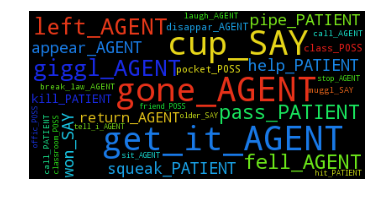

16
Topic  17
mother_POSS gang_POSS tongu_POSS father_POSS parent_POSS take_PATIENT hit_PATIENT whimper_AGENT bark_POSS basket_POSS bottom_POSS stick_POSS heel_POSS heart_POSS bag_POSS lip_POSS abl_MOD want_PATIENT anoth_SAY stop_AGENT night_SAY snarl_AGENT big_SAY help_SAY life_POSS shut_SAY soul_POSS friend_POSS dad_SAY ask__AGENT 


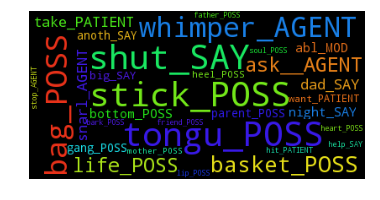

17
Topic  18
briefcas_POSS le_SAY teddi_SAY leave_offic_AGENT get_job_AGENT cloak_POSS start_AGENT tell_you_AGENT found_PATIENT happen_SAY arriv_AGENT minerva_SAY ah_SAY magic_SAY offic_POSS express_POSS take_PATIENT hat_POSS glare_AGENT find_PATIENT forc_PATIENT minist_SAY hold_PATIENT remain_SAY hurt_PATIENT remind_you_AGENT bring_PATIENT toe_POSS armi_POSS give_evid_AGENT 


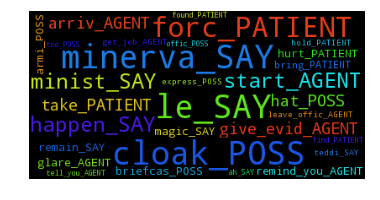

18
Topic  19
sure_MOD heart_POSS mind_POSS scar_POSS feel_AGENT glanc_AGENT stomach_POSS realiz_AGENT found_AGENT bed_POSS wonder_AGENT ask__AGENT start_AGENT trunk_POSS forehead_POSS chest_POSS move_AGENT onli_SAY glass_POSS notic_AGENT life_POSS er_SAY hagrid_SAY watch_PATIENT knee_POSS make_SAY watch_AGENT hurri_AGENT throat_POSS rememb_AGENT 


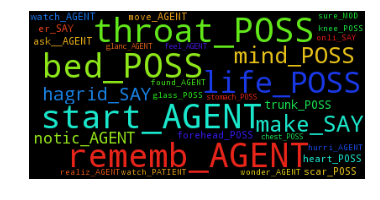

19
Topic  20
clipboard_POSS clipboard_POSS offic_POSS offic_POSS hem_SAY parti_POSS albus_SAY smile_POSS make_not_AGENT inquisitor_SAY handbag_POSS take_SAY hurt_SAY ought_SAY high_SAY detent_SAY stop_SAY brother_SAY camera_POSS cattermol_SAY hagrid_SAY door_POSS sign_SAY understand_SAY left_AGENT mother_SAY magic_SAY home_SAY watch_SAY blame__AGENT prize_SAY shorter_MOD 


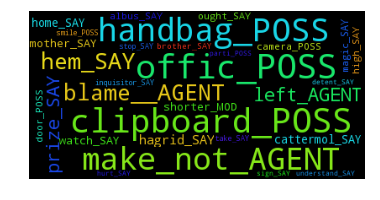

20
Topic  21
stick_POSS cauldron_POSS stop_AGENT leav_AGENT met_PATIENT becaus_SAY hogwart_SAY sit_AGENT mayb_SAY bed_POSS muggl_SAY roar_AGENT grin_AGENT hey_SAY diggori_SAY mother_SAY poster_POSS someth_SAY sure_SAY magic_SAY ministri_SAY need_SAY side_POSS anyth_SAY wizard_SAY year_SAY happen_SAY anyon_SAY do_what_AGENT quidditch_SAY 


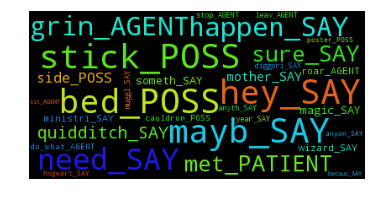

21
Topic  22
offic_POSS doe_SAY take_SAY becaus_SAY ad_AGENT need_SAY sure_SAY someth_SAY magic_SAY make_SAY hagrid_SAY onli_SAY year_SAY desk_POSS dark_SAY smile_AGENT snape_SAY death_SAY might_SAY continu_AGENT ministri_SAY way_SAY find_SAY move_AGENT sit_AGENT stand_AGENT last_SAY happen_SAY give_SAY ani_SAY 


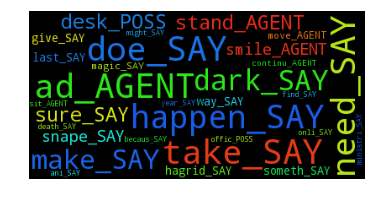

22
Topic  23
desk_POSS heir_POSS spectacl_POSS follow_PATIENT strode_AGENT eyebrow_POSS student_SAY offic_POSS glass_POSS nostril_POSS hous_SAY tell_they_AGENT hat_POSS monster_POSS tartan_POSS biscuit_SAY place_stool_AGENT alert_SAY blow_nos_AGENT repeat_AGENT barti_SAY partner_SAY work_POSS bark_PATIENT ball_SAY march_AGENT hall_SAY class_POSS new_SAY call_AGENT 


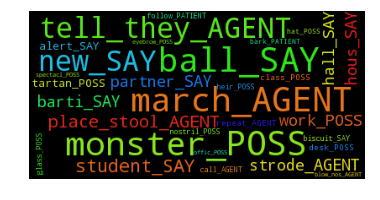

23
Topic  24
cage_POSS cage_POSS cage_POSS cage_POSS wing_POSS hoot_AGENT beak_POSS sent_PATIENT land_AGENT watch_PATIENT feather_POSS gone_AGENT return_AGENT send_PATIENT flutter_AGENT sway_AGENT kept_AGENT wing_SAY ad_AGENT soar_AGENT flew_AGENT angri_MOD reflect_POSS tray_POSS woken_AGENT give_a_AGENT click_beak_AGENT get_attent_AGENT drop_POSS pick_PATIENT screw_ey_AGENT hogsmead_SAY fault_SAY 


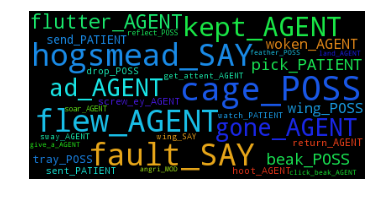

24


In [250]:
from wordcloud import WordCloud

from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages('topics.pdf')

%matplotlib inline
top_texts = []
for i in range(0, numtopics):
    print 'Topic ', i
    text = ""
    word_tups = lda.show_topic(i, 30)
    for tup in word_tups:
        scale = (int)(tup[0]*100 + 1)
        for j in range(scale):
            text += (tup[1])
            text += " "
    print text
    img = WordCloud(max_font_size=40, relative_scaling=.1).generate(text)
    # Display the generated image:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    if not os.path.exists("topics"):
        os.makedirs("topics")
    print str(i)
    name = 'Topic '+str(i)+'.png'
    img.to_file("topics//"+name)
#pp.close()

#### Create topic matrix (dimensions num_characters x num_topics) containing topic probabilities for each character

In [251]:
topic_matrix = [[0 for i in range(numtopics)] for namekey in names]
print len(topic_matrix)
i = 0
for namekey in names:
    print i, str(namekey) + " topic distribution: "
    for (key, value) in lda[corpus[names[namekey]]]:
        topic_matrix[i][key] = value
    i+=1
    print lda[corpus[names[namekey]]]

87
0 Fang topic distribution: 
[(17, 0.99244094488153722)]
1 Lupin topic distribution: 
[(5, 0.11749780354918589), (10, 0.057431849741197624), (18, 0.057686809794877857), (19, 0.062168173106928959), (22, 0.70438116151370211)]
2 Dudley topic distribution: 
[(17, 0.99821892393314271)]
3 Cho topic distribution: 
[(8, 0.99499999999972388)]
4 Fred topic distribution: 
[(7, 0.88016663948445084), (22, 0.11111076940489414)]
5 Hogwarts topic distribution: 
[(1, 0.99577092510881915)]
6 Kingsley topic distribution: 
[(8, 0.98814814814119556)]
7 Moody topic distribution: 
[(22, 0.99851393188822335)]
8 Winky topic distribution: 
[(6, 0.99478260869536372)]
9 James topic distribution: 
[(12, 0.99559633027506633)]
10 Voldemort topic distribution: 
[(5, 0.34249713192965786), (22, 0.65707195472137236)]
11 Bellatrix topic distribution: 
[(22, 0.99623529411743461)]
12 Albus Dumbledore topic distribution: 
[(19, 0.99580786026168311)]
13 Maxime topic distribution: 
[(0, 0.98117647058764124)]
14 Lockhart top

#### Bar plot visualization of above character topic probabilities

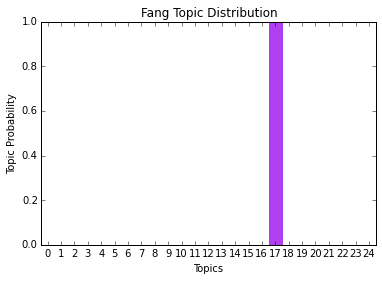

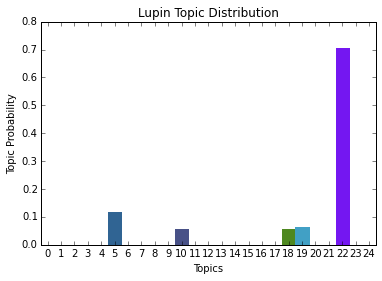

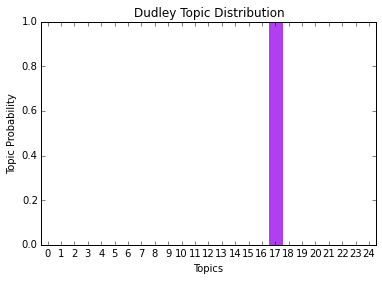

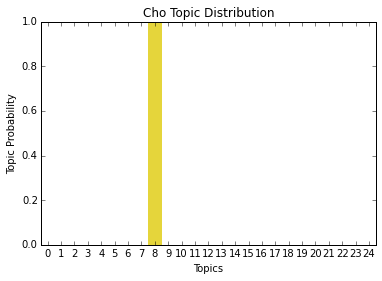

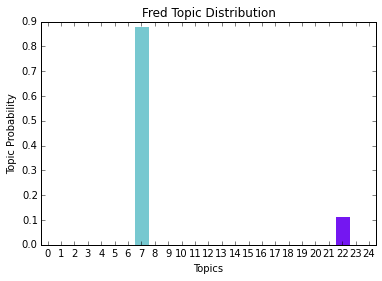

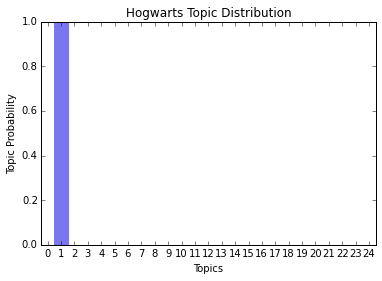

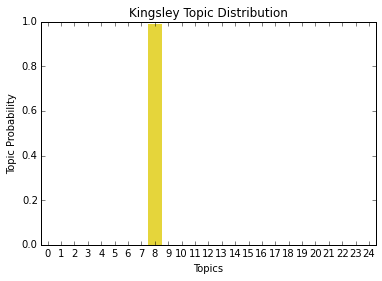

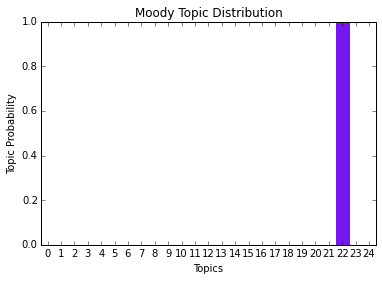

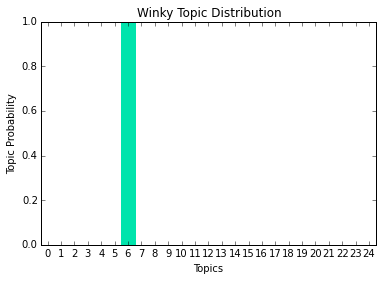

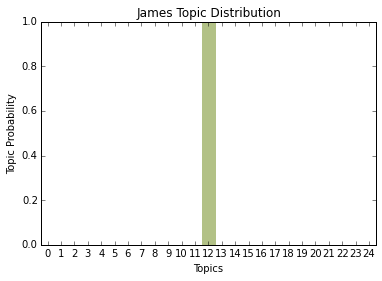

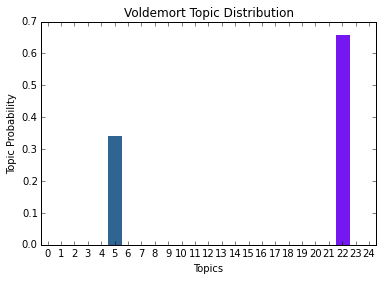

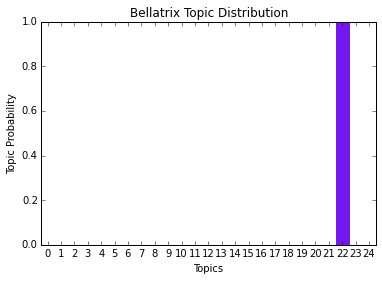

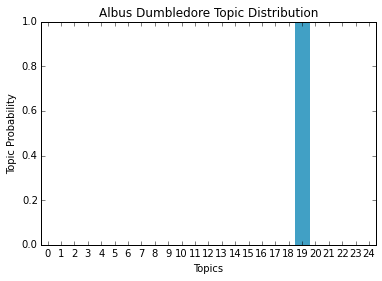

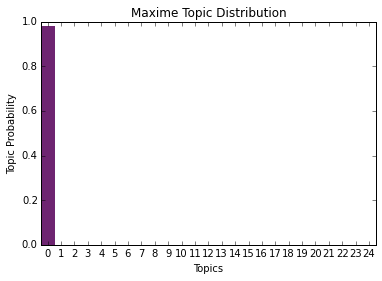

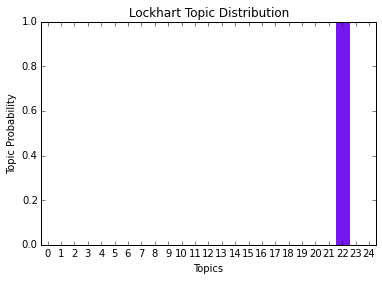

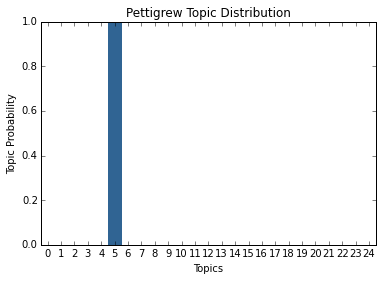

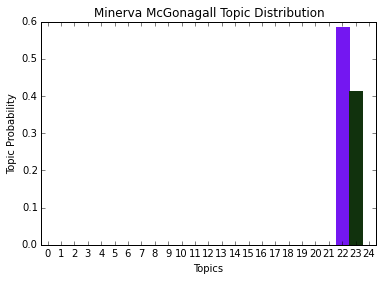

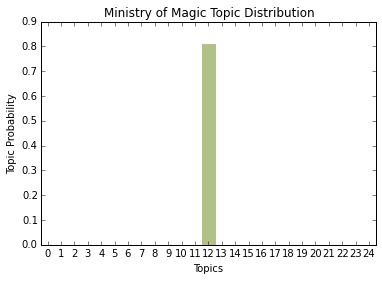

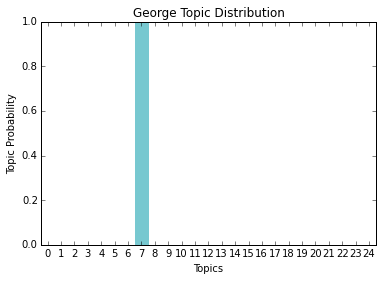

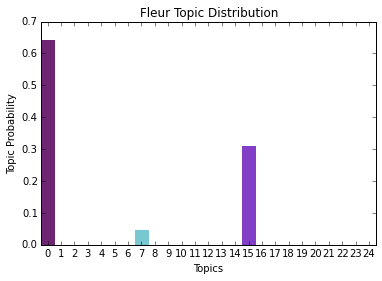

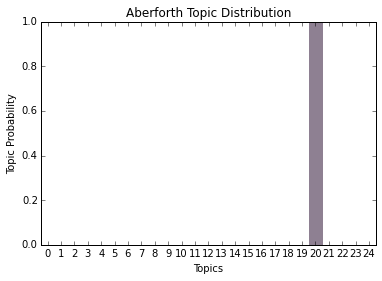

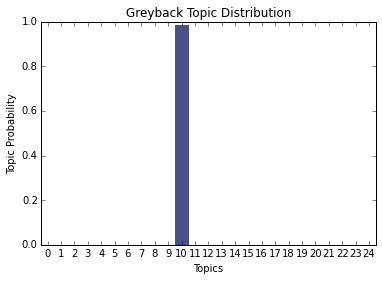

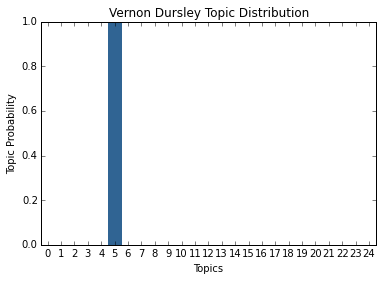

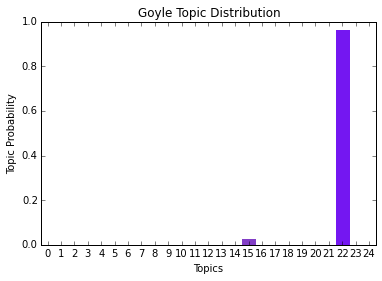

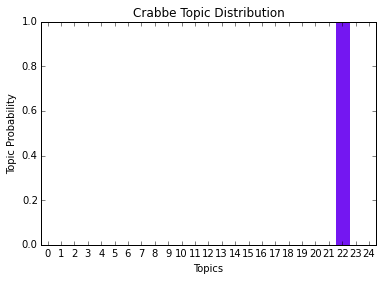

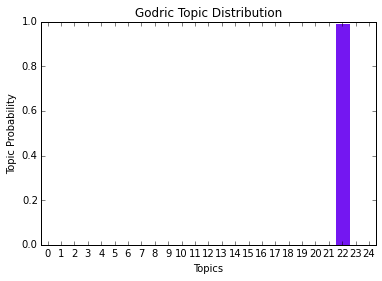

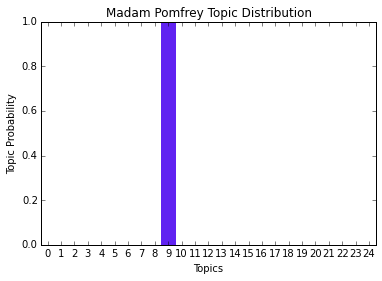

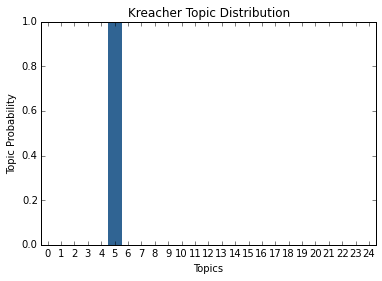

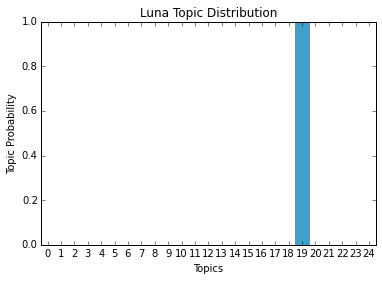

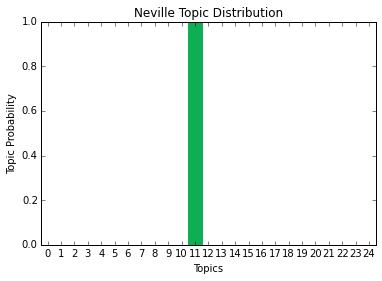

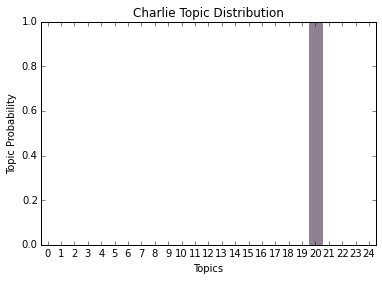

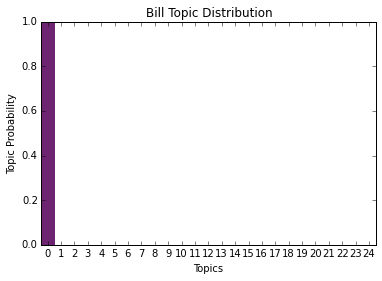

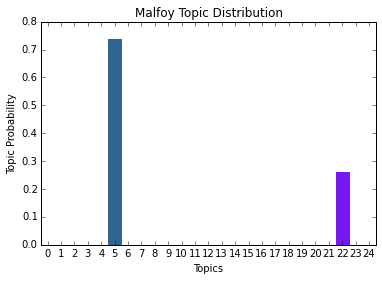

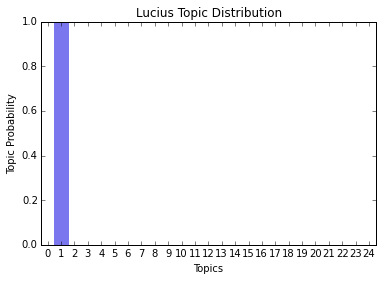

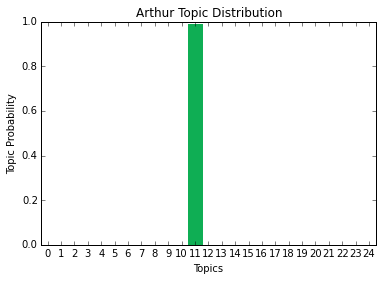

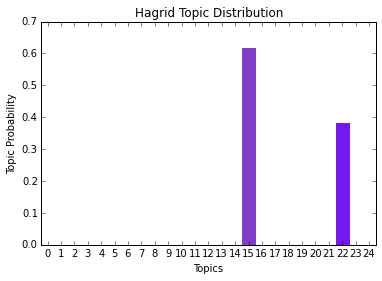

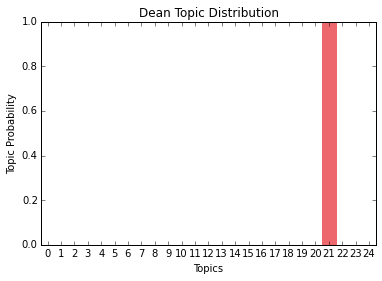

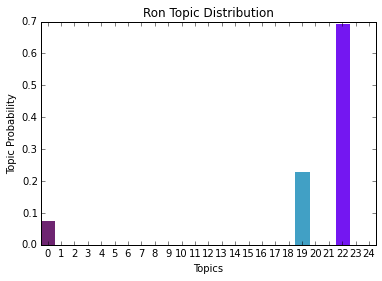

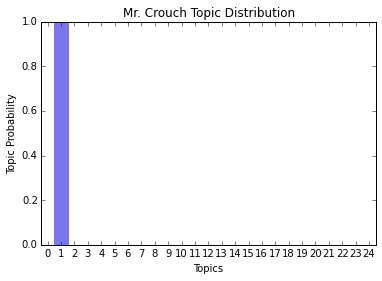

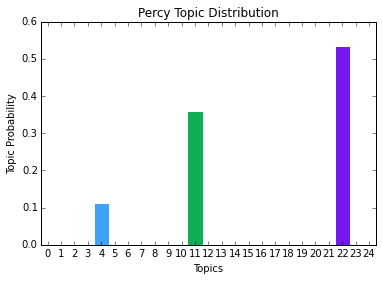

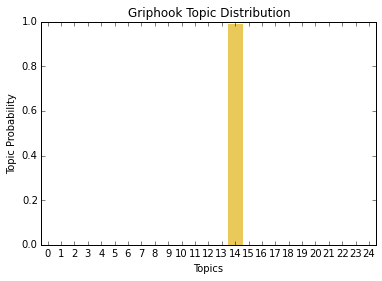

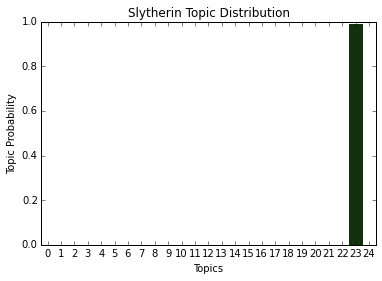

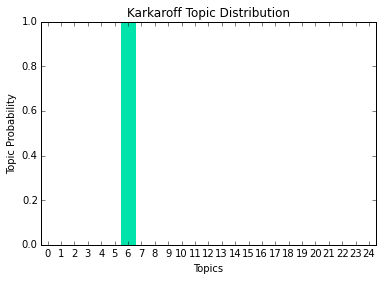

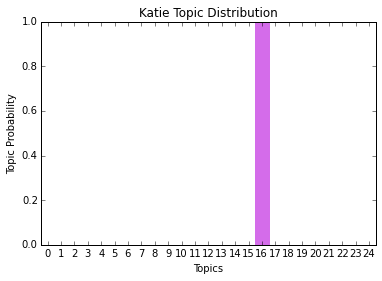

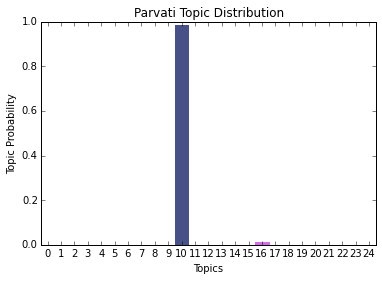

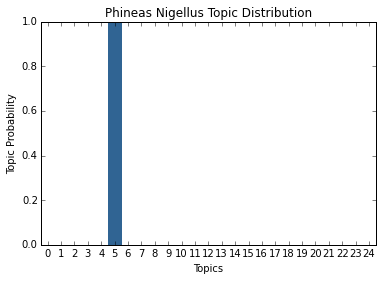

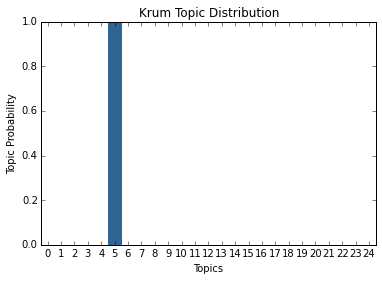

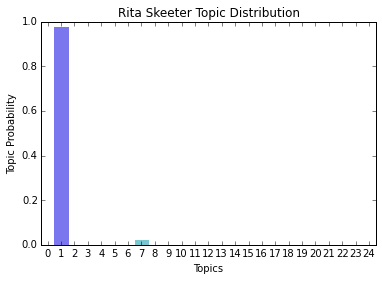

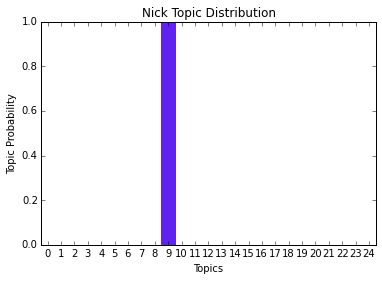

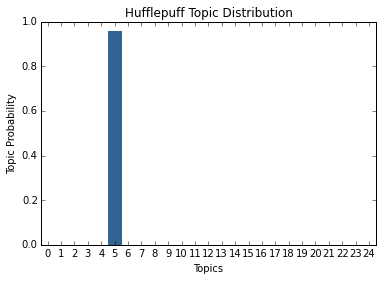

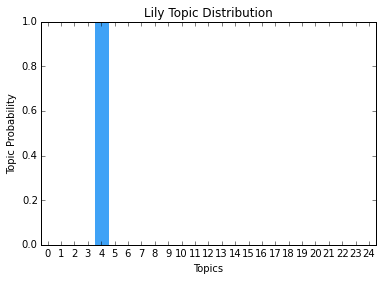

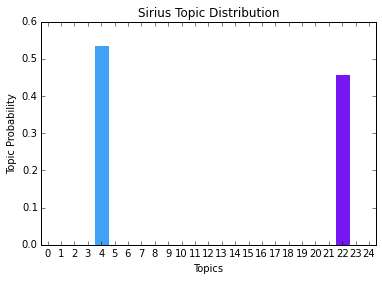

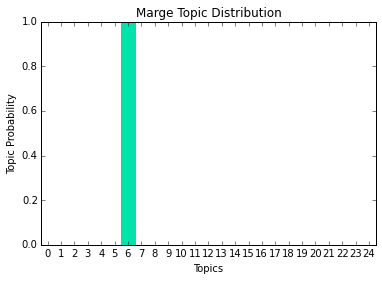

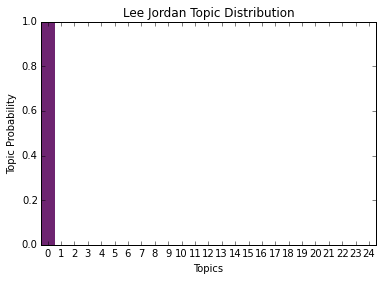

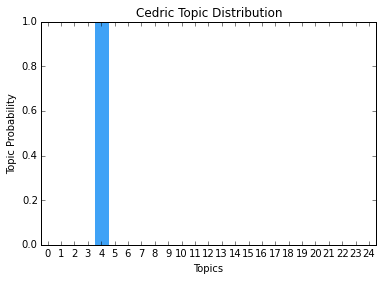

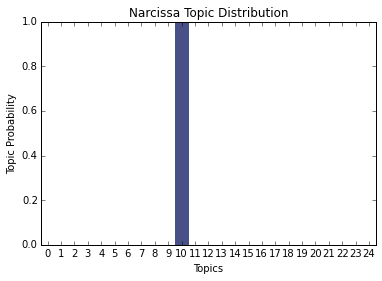

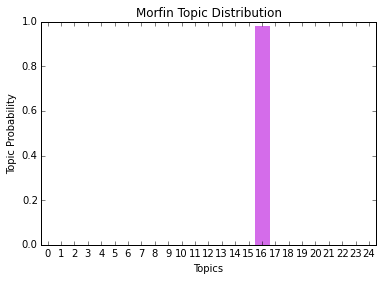

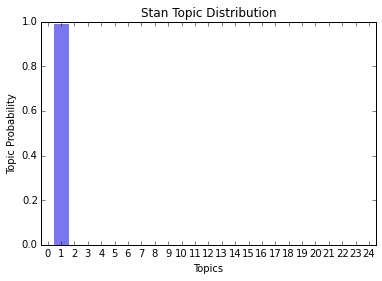

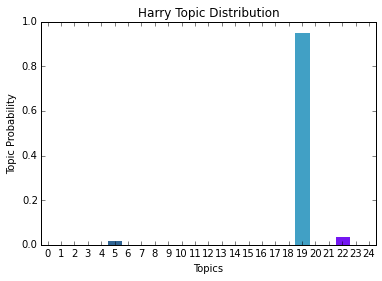

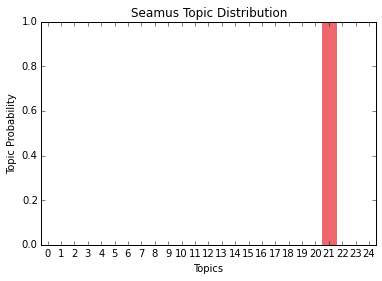

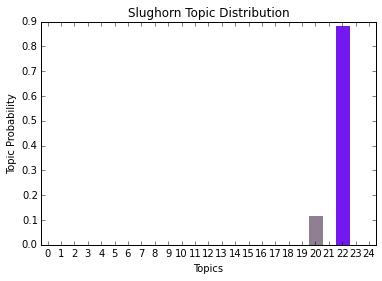

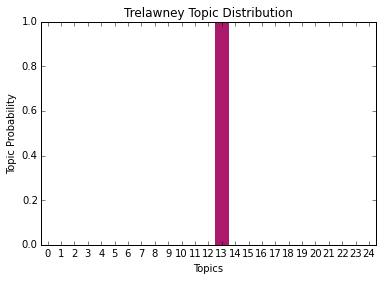

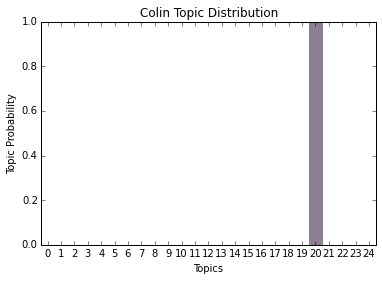

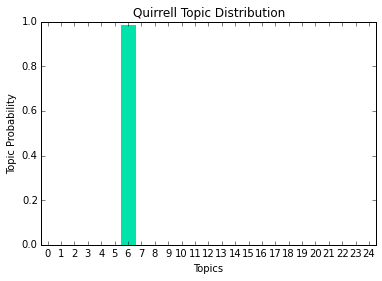

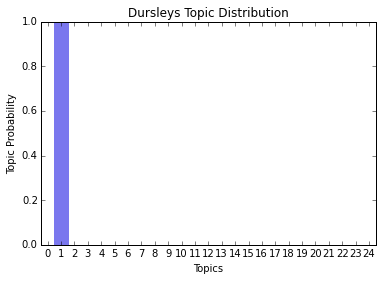

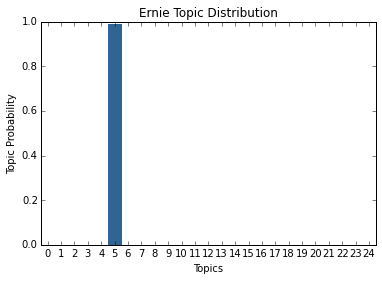

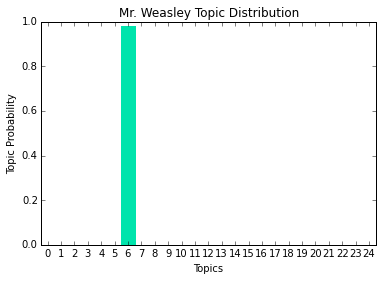

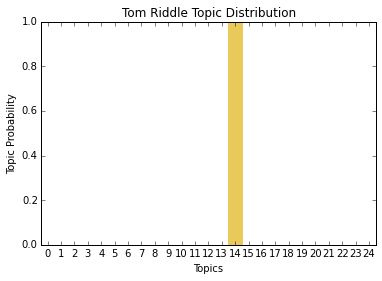

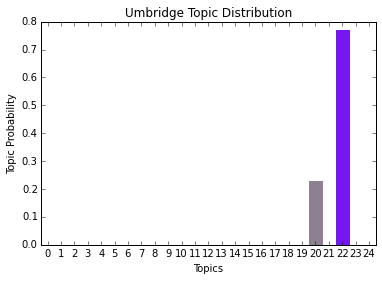

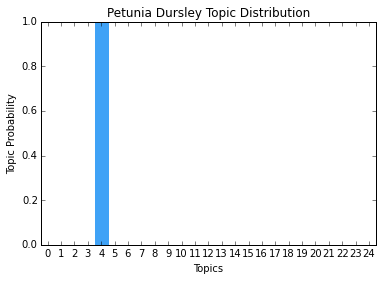

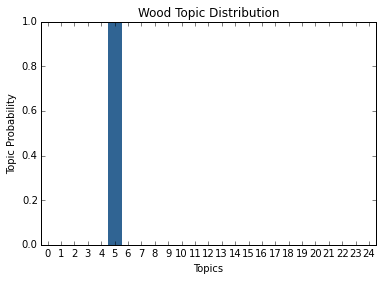

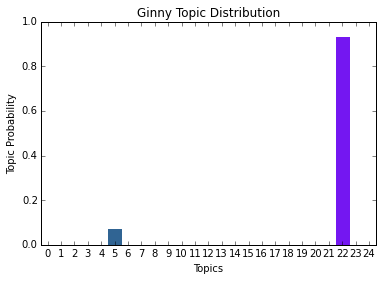

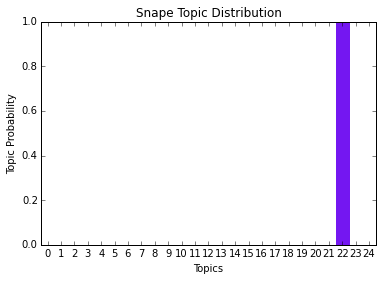

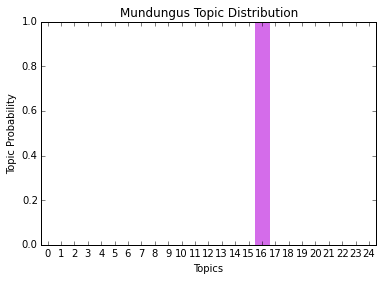

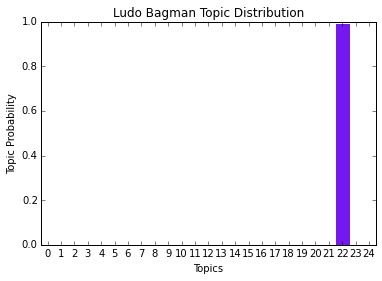

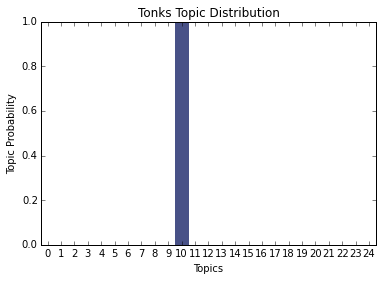

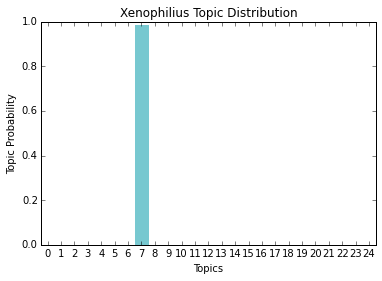

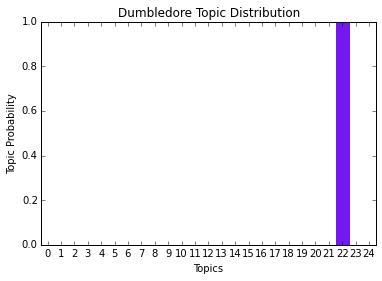

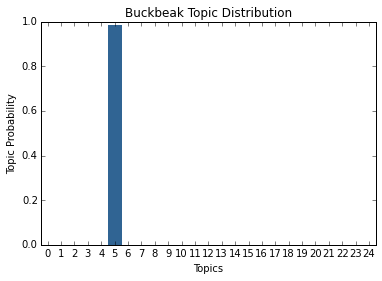

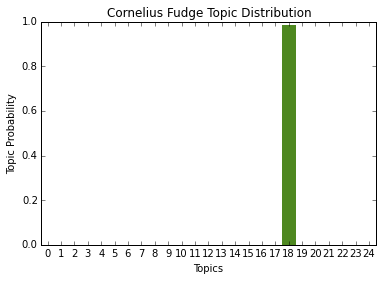

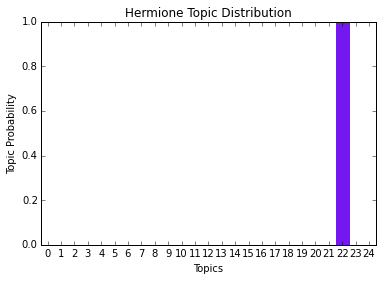

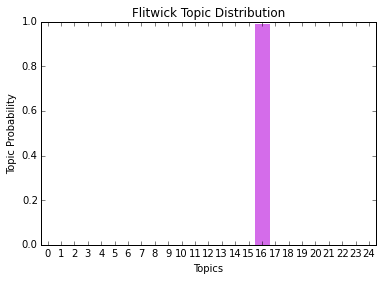

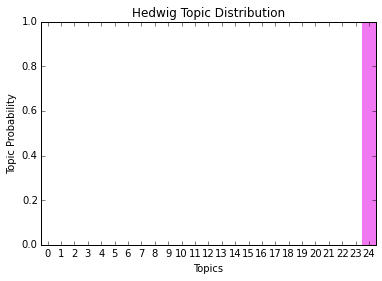

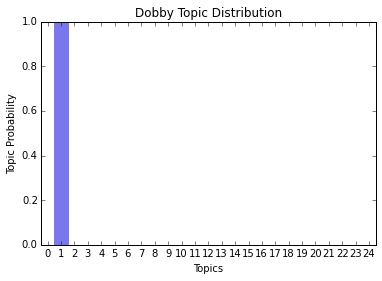

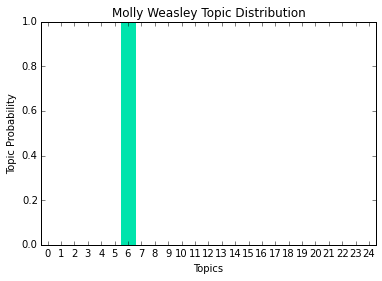

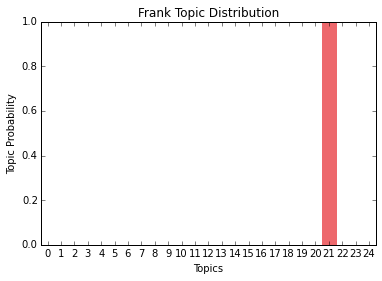

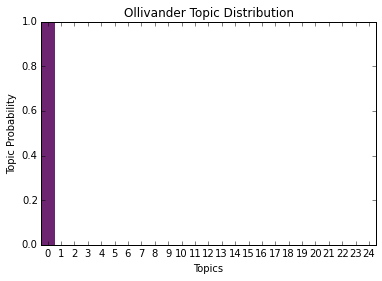

In [252]:
# Plot bar charts for each character's topics

# choose some random colors to represent each topic
topicColors = []
for i in range(numtopics):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    topicColors.append(color)

%matplotlib inline 

if not os.path.exists("char_topic_charts"):
    os.makedirs("char_topic_charts")

# iterate through the character topic vectors, making a plot for each
nameit = names.iterkeys()
for charArray in topic_matrix:
    ind = np.arange(len(charArray))  # the x locations for the topics
    fig, ax = plt.subplots()
    width = 1
    
    topicNames = []
    topicProbs = []
    for i in range(len(charArray)):
        topicNames.append(i)
    
    rects1 = ax.bar(ind, charArray, width)
    for i in range(len(charArray)):
        rects1[i].set_color(topicColors[topicNames[i]])
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Topic Probability')
    ax.set_xlabel('Topics')
    title =  nameit.next() + ' Topic Distribution'
    ax.set_title(title)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(topicNames)
    plt.savefig("char_topic_charts//"+title+".png")
    plt.show()
    


## Perform Clustering Based on Character Topic Vectors

The following code is heavily derivative of Brandon Rose's tutorial on topic modeling and clustering. 
http://brandonrose.org/clustering

#### Use KMeans (is this the best choice?) and print out the clusters list

In [253]:
data = np.array(topic_matrix)

from sklearn.cluster import KMeans
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data)
clusters = kmeans.labels_.tolist()
print clusters
# "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters."
goodness = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean')
print "silhouette score: " + str(goodness)
# within-cluster sum of squares
print "inertia: " + str(kmeans.inertia_)

[10, 1, 10, 12, 8, 2, 12, 1, 4, 12, 1, 1, 14, 5, 1, 3, 1, 12, 8, 5, 0, 6, 3, 1, 1, 1, 13, 3, 14, 12, 0, 5, 3, 2, 12, 12, 11, 1, 2, 1, 12, 12, 4, 7, 6, 3, 3, 2, 13, 3, 9, 9, 4, 5, 9, 6, 7, 2, 14, 11, 1, 12, 0, 4, 2, 3, 4, 12, 1, 9, 3, 1, 1, 7, 1, 6, 8, 1, 3, 12, 1, 7, 12, 2, 4, 11, 5]
silhouette score: 0.759916664008
inertia: 12.1471444335


#### Print out characters and cluster assignments (in order)

In [254]:
dic={}
i=0
for nameKey in names:
    dic[str(nameKey)]=clusters[i]
    i += 1
d=sorted(dic.items(), key=lambda x:x[1])
for name in d:
    print name

('Aberforth', 0)
('Charlie', 0)
('Colin', 0)
('Lupin', 1)
('Moody', 1)
('Voldemort', 1)
('Bellatrix', 1)
('Lockhart', 1)
('Minerva McGonagall', 1)
('Goyle', 1)
('Crabbe', 1)
('Godric', 1)
('Slughorn', 1)
('Percy', 1)
('Ron', 1)
('Umbridge', 1)
('Ginny', 1)
('Snape', 1)
('Ludo Bagman', 1)
('Dumbledore', 1)
('Hermione', 1)
('Hogwarts', 2)
('Lucius', 2)
('Mr. Crouch', 2)
('Rita Skeeter', 2)
('Stan', 2)
('Dursleys', 2)
('Dobby', 2)
('Pettigrew', 3)
('Vernon Dursley', 3)
('Kreacher', 3)
('Malfoy', 3)
('Phineas Nigellus', 3)
('Krum', 3)
('Hufflepuff', 3)
('Ernie', 3)
('Wood', 3)
('Buckbeak', 3)
('Winky', 4)
('Karkaroff', 4)
('Marge', 4)
('Quirrell', 4)
('Mr. Weasley', 4)
('Molly Weasley', 4)
('Maxime', 5)
('Fleur', 5)
('Bill', 5)
('Lee Jordan', 5)
('Ollivander', 5)
('Greyback', 6)
('Parvati', 6)
('Narcissa', 6)
('Tonks', 6)
('Katie', 7)
('Morfin', 7)
('Mundungus', 7)
('Flitwick', 7)
('Fred', 8)
('George', 8)
('Xenophilius', 8)
('Lily', 9)
('Sirius', 9)
('Cedric', 9)
('Petunia Dursley', 9)
('

#### Create data frame for clusters and characters

In [255]:
tempNameList = [nameKey for nameKey in names]
charClusts = {'characters': tempNameList, 'clusters': clusters}
frame = pd.DataFrame(charClusts, index = [clusters] , columns = ['character', 'clusters'])

In [256]:
frame['clusters'].value_counts() 

1     18
12    13
3     10
2      7
4      6
5      5
9      4
7      4
6      4
14     3
11     3
8      3
0      3
13     2
10     2
Name: clusters, dtype: int64

#### Show visual cluster plot 

In [257]:
# get euclidean distance between each character's topic vector
dist = euclidean_distances(data, data)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
    
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tempNameList)) 

#group by cluster
groups = df.groupby('label')

In [258]:
# assign cluster colors and names
cluster_colors = defaultdict(None)
cluster_names = defaultdict(None)
# randomly generate n colors based on the number of clusters desired
for i in range(len(clusters)):
    import random
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    cluster_colors[i] = color
    cluster_names[i] = i

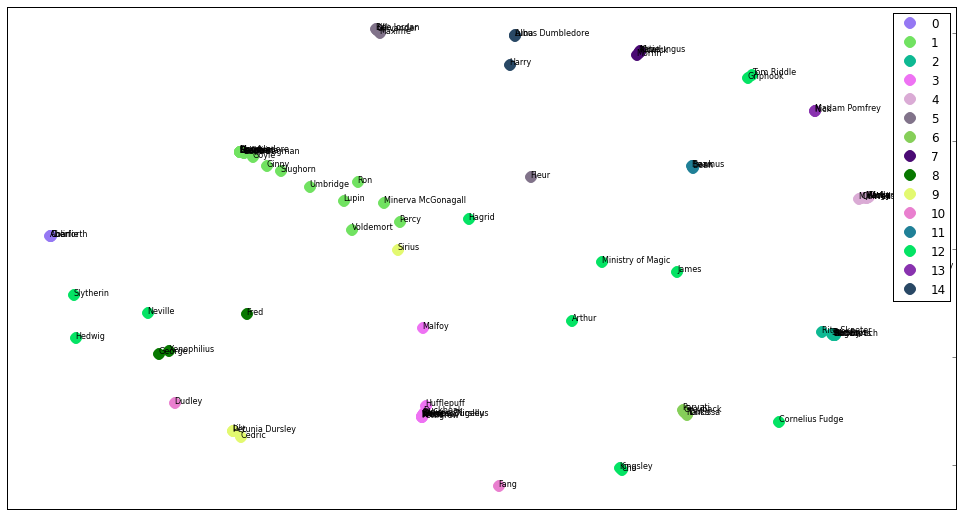

In [259]:
#The following is taken word for word from this tutorial: http://brandonrose.org/clustering

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  



plt.show() #show the plot


In [260]:
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)
plt.close()

#### Create and show dendrogram for the characters 

Again, taken almost verbatim from Brandon Rose's tutorial, implementation credit goes to him

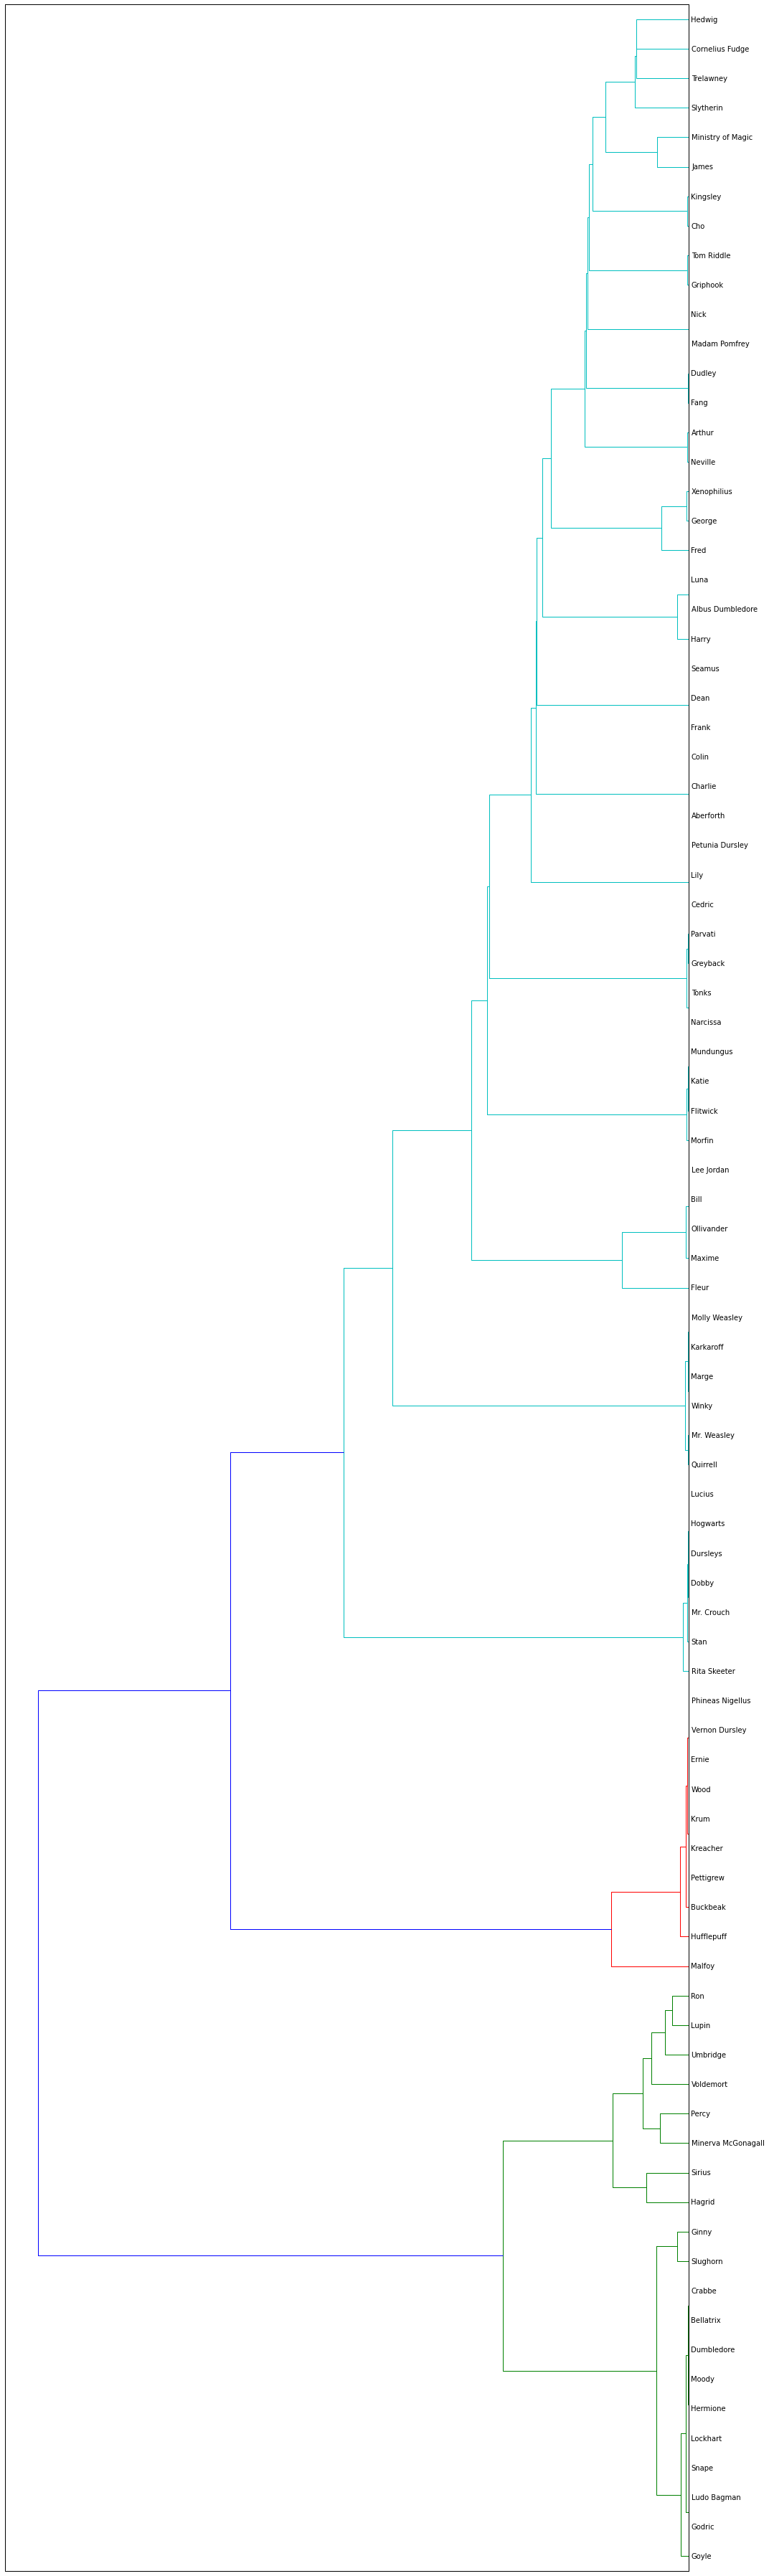

In [261]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=charClusts['characters']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Supervised Learning with Topics

 What follows is an attempt to use the characters' generated topic probabilities as features for supervised learning (specifically logistic regression). Based on our ground truth labeled information, we will see whether the topic assignments are informative/useful for predicting these labels or not.

In [262]:
# load our labeled character data (choose one of our annotated character files)
import getVectors
getVectors = reload(getVectors)
# labels = ['Muggles', 'Hogwarts Students', 'Hogwarts Teachers', 'Ministry Officials', 
#           'Quidditch Players', 'Gryffindors', 'Ravenclaws', 'Hufflepuffs','Slytherins',
#          'Muggle-borns','Purebloods','Half-bloods','Humans','Part Humans', 'Non-Humans',
#          'Death Eaters', 'Order of the Phoenix', 'Dumbledores Army','Animagi', 'Parselmouths',
#          'Convicts','Weasleys','Dead','Bullies', 'Victims']
#(vectors, charlist) = getVectors.getVectors("cluster.txt")
labels = ['Protagonists', 'Antagonists', 'Neutral', 'Animals']
(vectors, charlist) = getVectors.getVectors("good_bad_labels.txt")
print charlist

['Lupin', 'Cho', 'Albus Dumbledore', 'Lily', 'Cedric', 'Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Fred Weasley', 'George Weasley', 'Neville Longbottom', 'Ginny Weasley', 'Luna Lovegood', 'Dean Thomas', 'Oliver Wood', 'Rubeus Hagrid', 'Minerva McGonagall', 'Mad-Eye Moody', 'Arthur Weasley', 'Mr. Weasley', 'Tonks', 'Kingsley Shacklebolt', 'Viktor Krum', 'Sirius Black', 'Bill', 'Godric Gryffindor', 'Mrs. Weasley', 'Regulus', 'Fleur Delacour', 'Dobby', 'James Potter', 'Dudley', 'Malfoys', 'Yaxley', 'Goyle', 'Phineus Nigelus', 'Quirrell', 'Mr. Dursley', 'Mrs. Dursley', 'Aunt Marge', 'Draco Malfoy', 'Crabbe', 'Pansy Parkinson', 'Zacharias Smith', 'Montague', 'Severus Snape', 'Dolores Umbridge', 'Lucius', 'Cornelius Fudge', 'Barty Crouch', 'Peter Pettigrew', 'Voldemort', 'Bellatrix Lestrange', 'Salazar Slytherin', 'Narcissa Malfoy', 'Morfin', 'Antonin Dolohov', 'Rita Skeeter', 'Igor Karkaroff', 'Filch', 'Macnair', 'Travers', 'Fenrir Greyback', 'Kreacher', 'Griphook', 'Madam Hooch', '

In [263]:
# shuffle our samples
# combined = zip(charlist, vectors)
# random.shuffle(combined)
# charlist[:], vectors[:] = zip(*combined)

# just checking to make sure the vectors look right
# for i in range(len(vectors)):
#     print charlist[i]
#     print vectors[i]

In [264]:
# get a list of the indices for labeled characters that were recognized by book-nlp 
# (if they weren't returned in the character list, we can't classify them)
labeled = {}
j = 0 # index of character in labeled character list
for name in charlist:
    i = 0 # index of character in topic model vectors list
    found = False
    for name2 in names:
        #print name2
        if name.encode('UTF-8') in character_namelists[name2]:
            found = True
        elif not found == True:
            i+=1
    if found:
        # print name.encode('UTF-8')
        # tupe is topic vector index, charlist index
        labeled[name] = (j, i)
    #else:
        #print name.encode('UTF-8')
    j+=1
num_samples = len(labeled)
print num_samples

74


In [265]:
#print len(topic_matrix)
matrix = []
labeled_topic_matrix = []
labeled_chars = []
for char in labeled:
    #print char
    (charNameIndex, charTopicIndex) = labeled[char]
    print charNameIndex, charTopicIndex
    print charlist[charNameIndex]
    labeled_chars.append(charlist[charNameIndex])
    print vectors[charNameIndex]
    matrix.append(vectors[charNameIndex])
    print topic_matrix[charTopicIndex]              
    labeled_topic_matrix.append(topic_matrix[charTopicIndex])
    print

labeled_topic_matrix = np.array(labeled_topic_matrix) 
#print labeled_topic_matrix

labelmatrix = np.matrix(matrix)
#print labelmatrix

62 21
Fenrir Greyback
[0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.98628571428521616, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

5 58
Harry Potter
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0.015210362359885604, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9509448694115169, 0, 0, 0.033705270839698771, 0, 0]

17 7
Mad-Eye Moody
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99851393188844573, 0, 0]

11 71
Ginny Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0.06909561148890922, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.92892353704373232, 0, 0]

45 72
Severus Snape
[0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99759463647125324, 0, 0]

19 66
Mr. Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0.98021913627735724, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

52 11
Bellatrix Lestrange
[0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99623529411743394, 0, 0]

0 1
Lupin
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0.11749

In [266]:
from sklearn import linear_model
from sklearn import cross_validation


# choose the appropriate row to get your binary labels for feature i, then split it into a train/test set
# i.e. Muggles vs. not muggles, good guys vs. not good guys, etc.
for label in range(labelmatrix[0].size):
    print labels[label]
    #X_train, X_test, y_train, y_test = cross_validation.train_test_split(labeled_topic_matrix, labelmatrix[:,label], test_size=0.4, random_state=0)
    logreg = linear_model.LogisticRegression(C=1e5)
    # train
    #logreg.fit(X_train, y_train)
    #Z = logreg.predict(X_test)
    #print "accuracy: ", logreg.score(X_test, y_test)
    # print Z
    print "Accuracy:"
    accuracyScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2)
    print accuracyScores
    print "Precision:"
    precisionScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'precision')
    print precisionScores
    print "Recall:"
    recallScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'recall')
    print recallScores
    print

Protagonists
Accuracy:
[ 0.65789474  0.63888889]
Precision:
[ 0.5625      0.53333333]
Recall:
[ 0.6         0.57142857]

Antagonists
Accuracy:
[ 0.60526316  0.61111111]
Precision:
[ 0.16666667  0.25      ]
Recall:
[ 0.09090909  0.2       ]

Neutral
Accuracy:
[ 0.65789474  0.63888889]
Precision:
[ 0.42857143  0.33333333]
Recall:
[ 0.54545455  0.3       ]

Animals
Accuracy:
[ 0.78947368  0.83333333]
Precision:
[ 0.2  0. ]
Recall:
[ 1.  0.]

